In [516]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

In [517]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0,
                    8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9,
                    33.9, 21.8, 48.4, 60.4, 68.4])

In [518]:
def model(t_u, w1, w2, b):
    return w2 * t_u ** 2 + w1 * t_u + b

In [519]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [520]:
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [521]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params) # <1>
        loss = loss_fn(t_p, t_c)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [522]:
params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1.5e-1
optimizer = optim.Adam([params], lr=learning_rate) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params,
    t_u = t_u, # <2> 
    t_c = t_c)

Epoch 500, Loss 4.353551
Epoch 1000, Loss 3.520451


Epoch 1500, Loss 3.408525
Epoch 2000, Loss 3.373695
Epoch 2500, Loss 3.332062
Epoch 3000, Loss 3.279436
Epoch 3500, Loss 3.214274
Epoch 4000, Loss 3.135191
Epoch 4500, Loss 3.041306
Epoch 5000, Loss 2.932696


tensor([-0.0400,  0.0054, -3.2923], requires_grad=True)

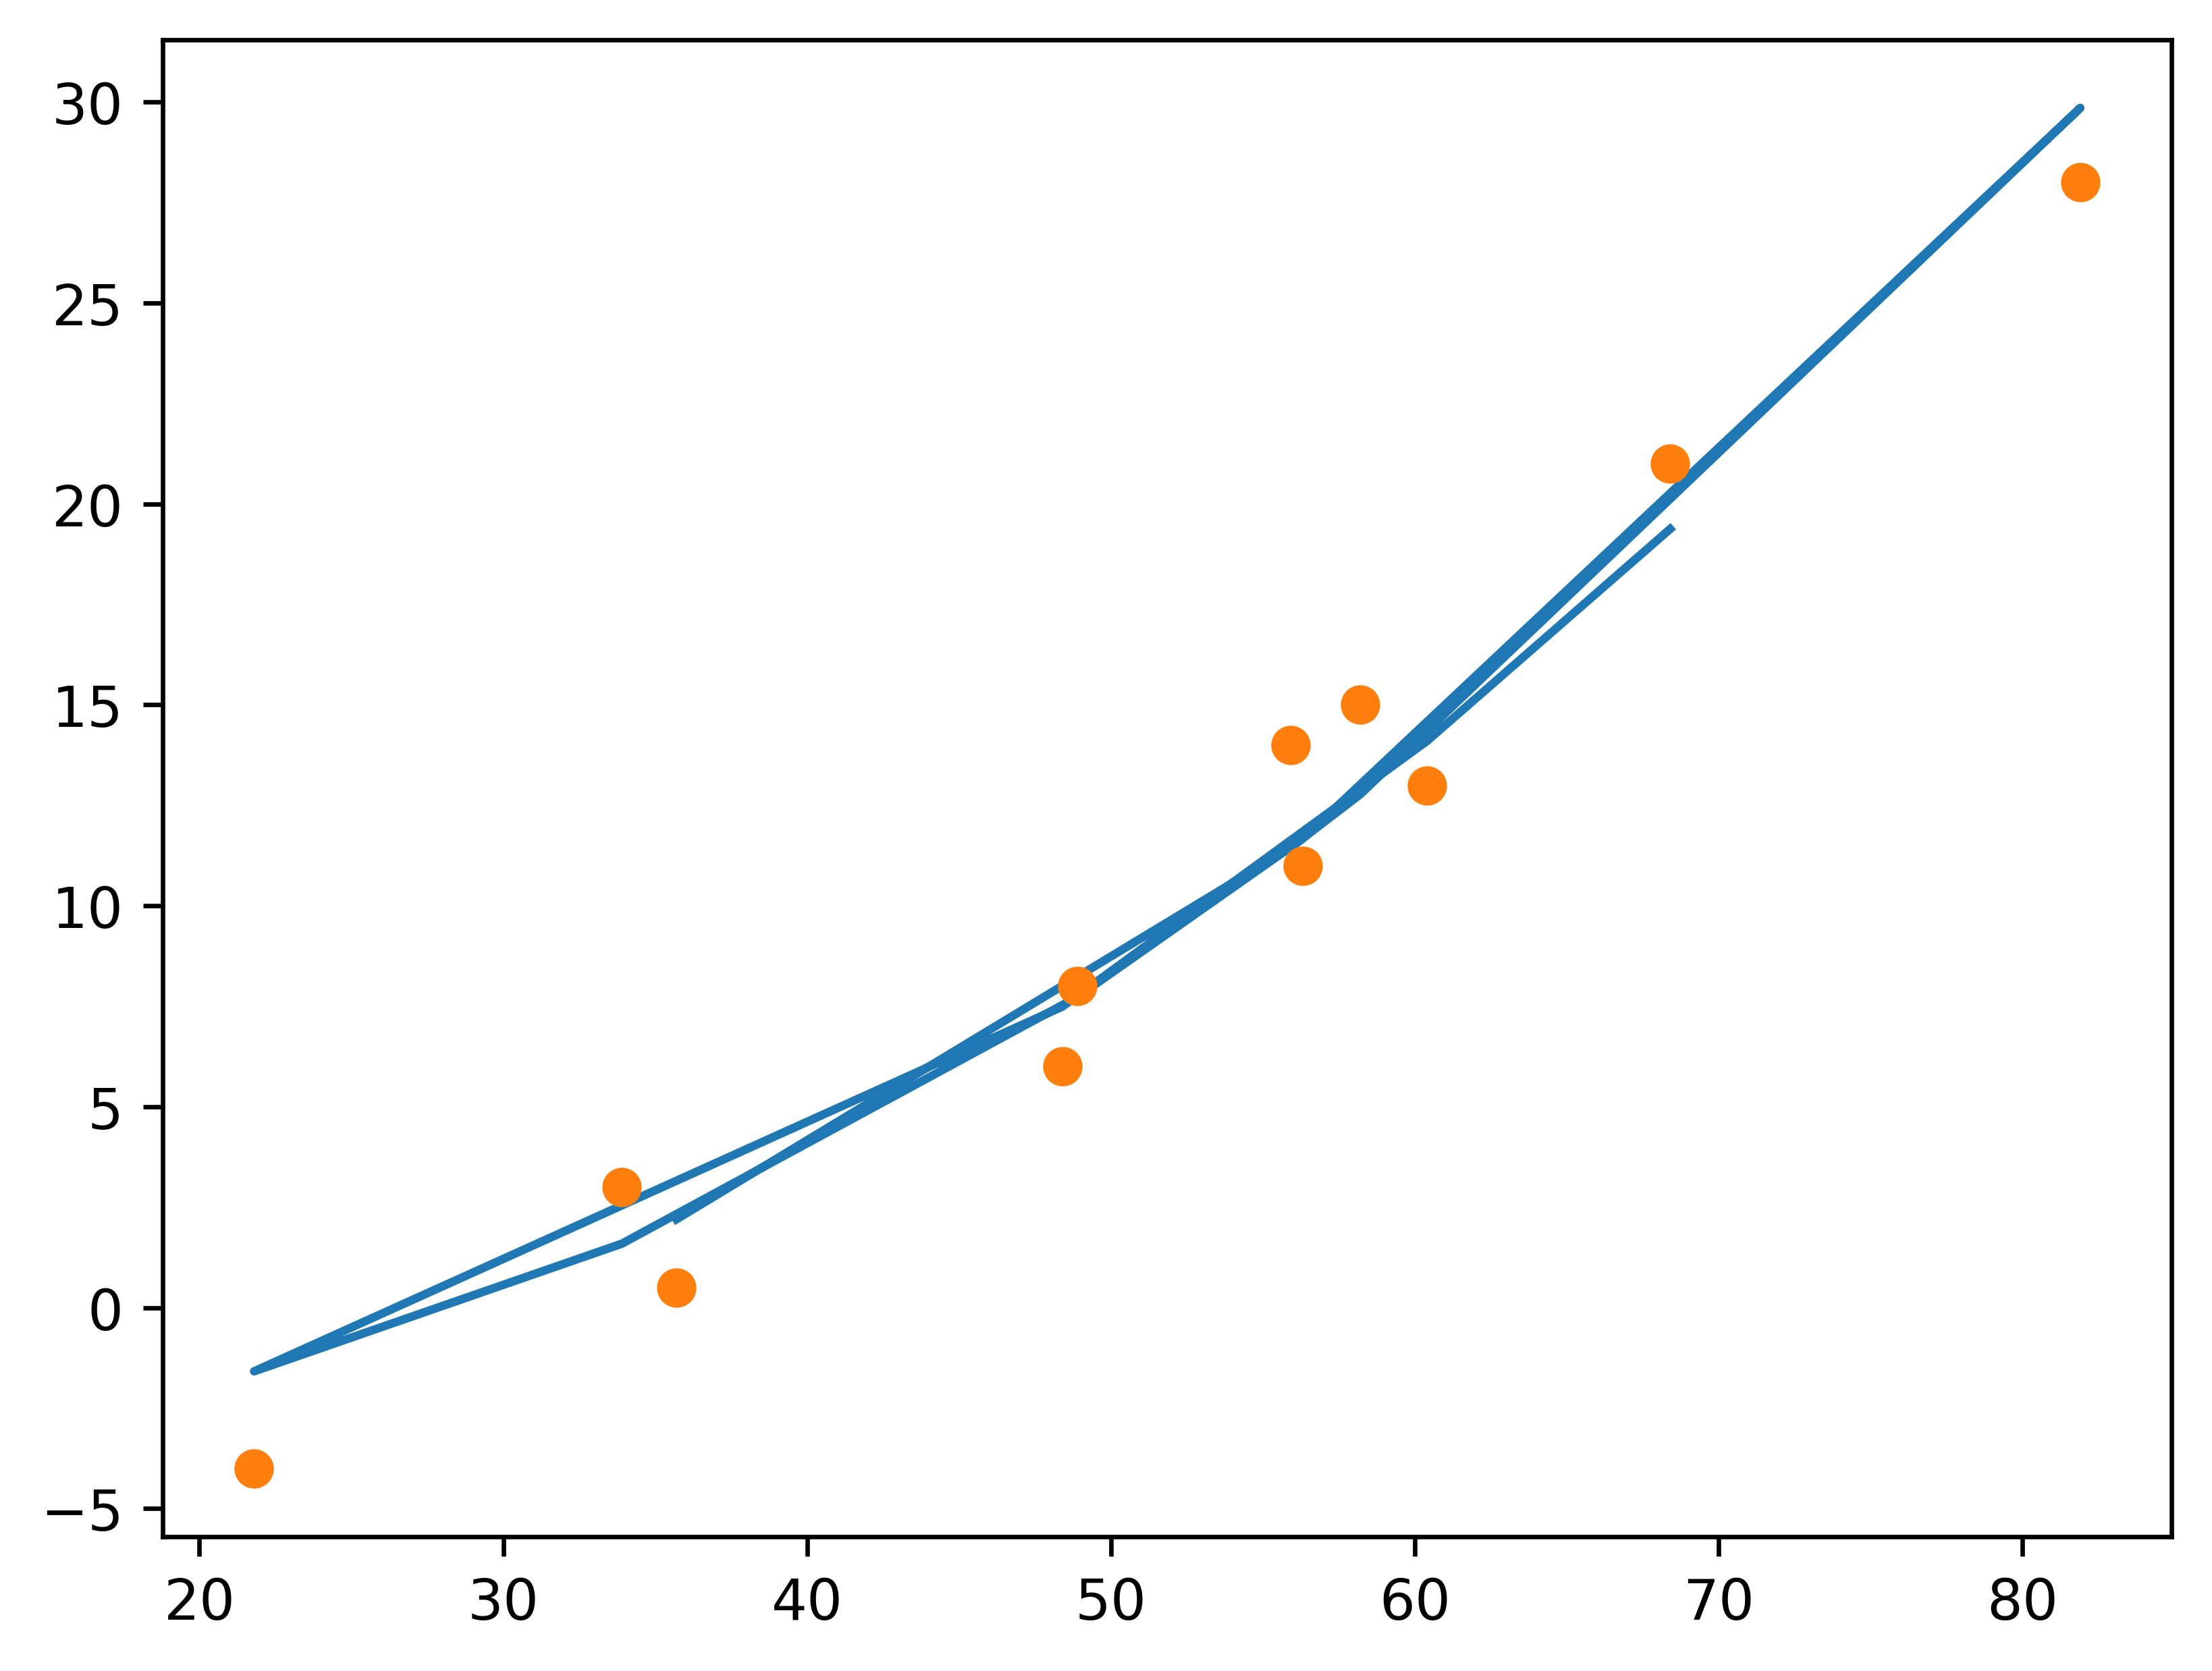

In [523]:
import matplotlib.pyplot as plt

t_p = model(t_u, *params)

fig = plt.figure(dpi=600)
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")

In [524]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

In [525]:
shuffled_indices = torch.randperm(n_samples)

In [526]:
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
train_indices, val_indices

(tensor([10,  9,  2,  4,  7,  1,  3,  0,  6]), tensor([8, 5]))

In [527]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

In [528]:
train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [529]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params) # <1>
        train_loss = loss_fn(train_t_p, train_t_c)
                             
        val_t_p = model(val_t_u, *params) # <1>
        val_loss = loss_fn(val_t_p, val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward() # <2>
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
            
    return params

In [530]:
params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(
    n_epochs = 2000, 
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un,
    val_t_u = val_t_un,
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 722.8059, Validation loss 464.2423
Epoch 2, Training loss 516.0112, Validation loss 345.8092
Epoch 3, Training loss 345.7136, Validation loss 245.5638


Epoch 500, Training loss 3.0454, Validation loss 1.3758
Epoch 1000, Training loss 2.5777, Validation loss 1.7296
Epoch 1500, Training loss 2.2394, Validation loss 2.1836
Epoch 2000, Training loss 2.0737, Validation loss 2.6209


tensor([ 2.3411,  0.2892, -9.8685], requires_grad=True)

In [531]:
def sort_t(t):
    t_sorted, indeices = t.sort()
    return t_sorted

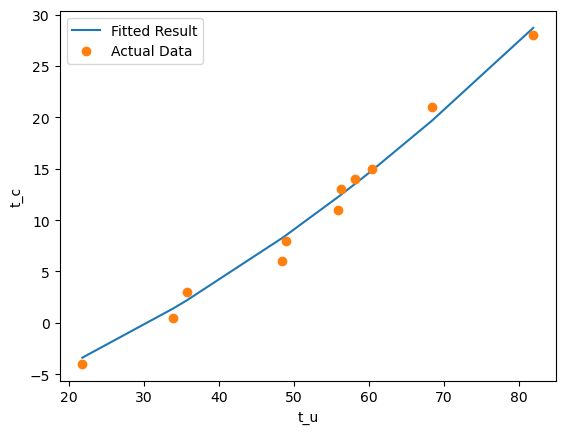

In [532]:
import matplotlib.pyplot as plt

t_p = model(t_u / 10, *params)

plt.plot(sort_t(t_u).numpy(), sort_t(t_p).detach().numpy(), label='Fitted Result')
plt.plot(sort_t(t_u).numpy(), sort_t(t_c).numpy(), 'o', label='Actual Data')
plt.xlabel('t_u')
plt.ylabel('t_c')
plt.legend()
plt.show()


对比二者的`Validation loss`和`Training loss`, 其指都小于原直线的, 所以我认为这个模型是有效的. 损失是低的, 实际结果是更好的.

而且图形上也更好看 :D

> IDK, 运行多几次之后发现并不是确定可以稳定下降的, 有时候会有明显的波动, 现在是对好的一次, 有时候会有明显的波动, 使得`Validation loss`(5.~)远大于`Training loss`, which看起来是过拟合了(??)